<a href="https://colab.research.google.com/github/anilsah895/skin_diseases_detection/blob/master/Using_a_pre_trained_1convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Base_dir="gdrive/My Drive/Colab Notebooks/Skin_Data1/"#content/gdrive/My Drive/Colab Notebooks/Skin_Data1
train_path = Base_dir+"train"
validation_path = Base_dir+"validation"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
#local_weights_file = "gdrive/My Drive/skindata/vgg16_weights_tf_dim_ordering_tf_kernels.h5"

pre_trained_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

#pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers[:11]:
  layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
#conv_base.summary()
with open(Base_dir+"MODEL_SUMMARY_FILE.text","w") as fh:
    pre_trained_model.summary(print_fn=lambda line: fh.write(line + "\n"))

In [0]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 512)


In [0]:
import tensorflow as tf
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.9885):
      print("\nReached 98.85% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
model = models.Sequential()
model.add(pre_trained_model)
#model.add(layers.Flatten())
#model.last_layer.output()
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#pre_trained_model.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 17,179,146
Non-trainable params: 1,735,488
_________________________________________________________________


In [0]:
#from keras import models
from keras.preprocessing.image import ImageDataGenerator
callback1=myCallback()

model.compile(optimizer = optimizers.RMSprop(lr=0.00003, rho=0.9, epsilon=1e-08, decay=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
# Change the batchsize according to your system RAM
train_batchsize = 64
val_batchsize = 32
 
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(150, 150),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
callbacks=[callback1])

Found 4400 images belonging to 10 classes.
Found 1100 images belonging to 10 classes.
Epoch 1/100
69/68 [==============================] - 1216s 18s/step - loss: 1.7023 - acc: 0.4040 - val_loss: 1.5960 - val_acc: 0.4691
Epoch 2/100
69/68 [==============================] - 50s 732ms/step - loss: 1.4301 - acc: 0.5114 - val_loss: 1.3643 - val_acc: 0.5336
Epoch 3/100
69/68 [==============================] - 53s 772ms/step - loss: 1.3098 - acc: 0.5548 - val_loss: 1.3681 - val_acc: 0.5364
Epoch 4/100
69/68 [==============================] - 53s 771ms/step - loss: 1.2179 - acc: 0.5770 - val_loss: 1.3881 - val_acc: 0.5445
Epoch 5/100
69/68 [==============================] - 52s 759ms/step - loss: 1.1283 - acc: 0.6081 - val_loss: 1.3370 - val_acc: 0.5564
Epoch 6/100
69/68 [==============================] - 53s 764ms/step - loss: 1.0540 - acc: 0.6414 - val_loss: 1.3602 - val_acc: 0.5409
Epoch 7/100
69/68 [==============================] - 53s 763ms/step - loss: 0.9868 - acc: 0.6555 - val_loss: 1

In [0]:
model.save(Base_dir+'skin_net100.hdf5')


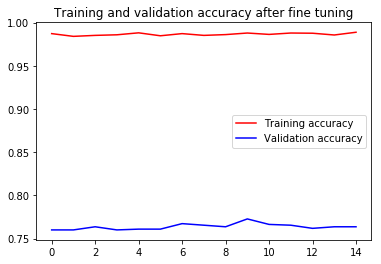

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy after fine tuning')
plt.legend(loc=0)
plt.savefig(Base_dir+"TRAINING_PLOT_FILE.png", bbox_inches='tight')
plt.savefig(Base_dir+"TRAINING_PLOT_FILE.png", bbox_inches='tight')

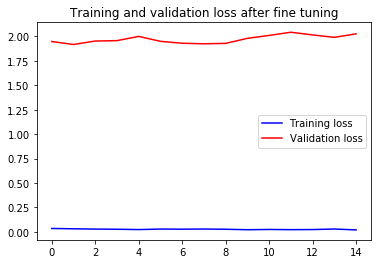

In [0]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss after fine tuning')
plt.legend()
plt.savefig(Base_dir+"VALIDATION_PLOT_FILE.png", bbox_inches='tight')
plt.savefig(Base_dir+"VALIDATION_PLOT_FILE.png", bbox_inches='tight')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 17,179,146
Non-trainable params: 1,735,488
_________________________________________________________________


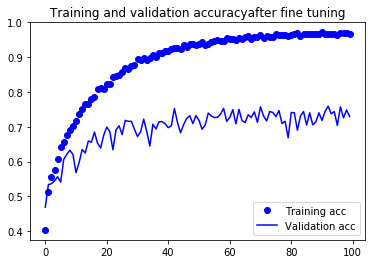

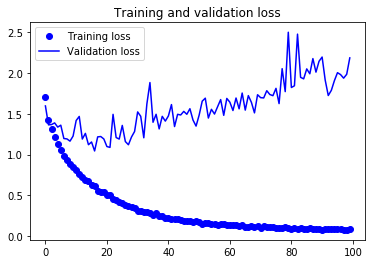

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracyafter fine tuning')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
pre_trained_model.trainable = True

set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



In [0]:
model.compile(optimizer = optimizers.RMSprop(lr=0.000003, rho=0.9, epsilon=1e-08, decay=0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 18,914,634
Trainable params: 11,279,370
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
callback1=myCallback()
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
callbacks=[callback1])

Epoch 1/50
69/68 [==============================] - 55s 798ms/step - loss: 0.0346 - acc: 0.9872 - val_loss: 1.9476 - val_acc: 0.7600
Epoch 2/50
69/68 [==============================] - 51s 739ms/step - loss: 0.0312 - acc: 0.9841 - val_loss: 1.9173 - val_acc: 0.7600
Epoch 3/50
69/68 [==============================] - 51s 735ms/step - loss: 0.0282 - acc: 0.9853 - val_loss: 1.9524 - val_acc: 0.7636
Epoch 4/50
69/68 [==============================] - 51s 740ms/step - loss: 0.0266 - acc: 0.9859 - val_loss: 1.9566 - val_acc: 0.7600
Epoch 5/50
69/68 [==============================] - 51s 734ms/step - loss: 0.0232 - acc: 0.9882 - val_loss: 1.9999 - val_acc: 0.7609
Epoch 6/50
69/68 [==============================] - 51s 733ms/step - loss: 0.0287 - acc: 0.9846 - val_loss: 1.9496 - val_acc: 0.7609
Epoch 7/50
69/68 [==============================] - 51s 734ms/step - loss: 0.0271 - acc: 0.9873 - val_loss: 1.9298 - val_acc: 0.7673
Epoch 8/50
69/68 [==============================] - 51s 734ms/step - 

In [0]:
model.save(Base_dir+'skin_net_after_fineTuning15.hdf5')


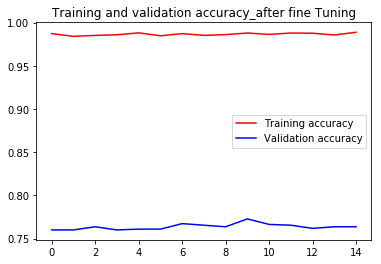

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy_after fine Tuning')
plt.legend(loc=0)
plt.savefig(Base_dir+"TRAINING_PLOT_FILE_after_fineTune.png", bbox_inches='tight')

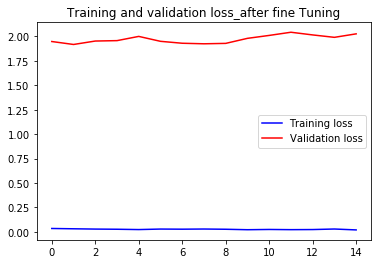

In [0]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss_after fine Tuning')
plt.legend()
plt.savefig(Base_dir+"VALIDATION_PLOT_FILE_with_finetune.png", bbox_inches='tight')

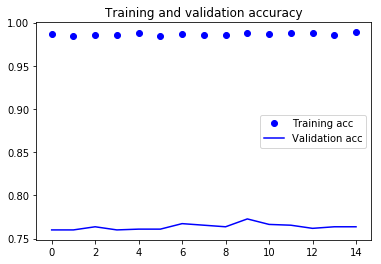

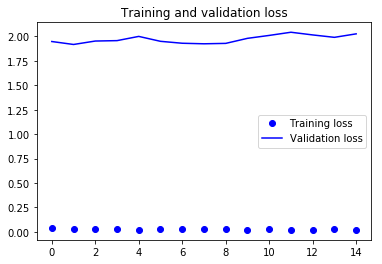

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving alopecia-areata-17.jpg to alopecia-areata-17 (4).jpg
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
The predicted disease found to be  Hair Loss Alopecia and other Hair Diseases
]8;;https://www.mayoclinic.org/diseases-conditions/nail-fungus/diagnosis-treatment/drc-20353300Ctrl+Click here]8;;


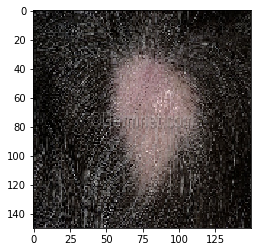

In [0]:
from keras.models import load_model
from google.colab import files
from keras.preprocessing import image
import numpy as np
from matplotlib.pyplot import imshow
from keras.applications.imagenet_utils import preprocess_input
import scipy.misc

model = load_model(Base_dir+'skin_net_after_fineTuning15.hdf5')
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
CATEGORIES =["Acne-Rosacea", "Basal cell carcinoma"," Hair Loss Alopecia and other Hair Diseases",
             " Herpes"," Melanoma Skin Cancer Nevi and Moles",
            " Nail Fungus and other Nail Disease" , "Urticaria Hives"," Vasculitis"," Warts","seborrheic-keratoses"]
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  #print('Input image shape:', x.shape)
  
  images = np.vstack([x])
  classes = model.predict(images)#, batch_size=10)
  #print(fn)
  
  print(classes[0])
  maximum=0.9
  for i,value in enumerate(classes[0]):
    if value>maximum:
      index=i
  print("The predicted disease found to be "+CATEGORIES[index]) 
  #print(type(CATEGORIES[int(classes[0][0])]))  
  
 

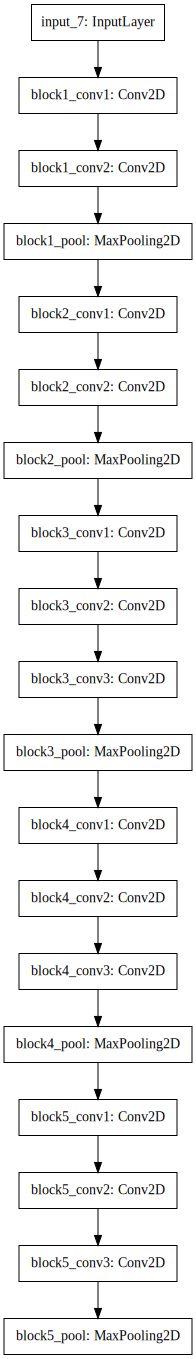

In [0]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
%matplotlib inline
plot_model(pre_trained_model, to_file=Base_dir+'model.png')
SVG(model_to_dot(pre_trained_model).create(prog='dot', format='svg'))


In [0]:
import cv2
import tensorflow as tf

CATEGORIES =["Acne-Rosacea", "Basal cell carcinoma"," Hair Loss Alopecia and other Hair Diseases",
             " Herpes"," Melanoma Skin Cancer Nevi and Moles",
            " Nail Fungus and other Nail Disease" , "Urticaria Hives"," Vasculitis"," Warts","seborrheic-keratoses"]
uploaded = files.upload()


def prepare(filepath):
    IMG_SIZE = 50  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


model = tf.keras.models.load_model("64X3-Cnn.model")

prediction = model.predict([prepare('rash30.jpg')])
print(int(prediction))  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])